[0.06011399 0.4413529 ]
Z:
[0.51141749 0.97738979]
[0.51141749 0.97738979]
[0.06011399 0.4413529 ]
J:
0.2455051979933081
Z:
[-0.18742288 -0.08584557]
[-0.18742288 -0.08584557]
[0.06011399 0.4413529 ]
J:
0.16960636442135424
Z:
[-0.19265741 -0.09187625]
[-0.19265741 -0.09187625]
[0.06011399 0.4413529 ]
J:
0.17411335058661415
Z:
[-0.18344822 -0.07717685]
[-0.18344822 -0.07717685]
[0.06011399 0.4413529 ]
J:
0.16409782269284778
Z:
[-0.17420912 -0.06287154]
[-0.17420912 -0.06287154]
[0.06011399 0.4413529 ]
J:
0.1545748026295057
Z:
[-0.16533542 -0.04928624]
[-0.16533542 -0.04928624]
[0.06011399 0.4413529 ]
J:
0.14577709963125418
Z:
[-0.15659963 -0.03598333]
[-0.15659963 -0.03598333]
[0.06011399 0.4413529 ]
J:
0.1374073334732908
Z:
[-0.14786757 -0.02272209]
[-0.14786757 -0.02272209]
[0.06011399 0.4413529 ]
J:
0.12931096301664244
Z:
[-0.1390936  -0.00941597]
[-0.1390936  -0.00941597]
[0.06011399 0.4413529 ]
J:
0.12143811710928197
Z:
[-0.13028002  0.00394057]
[-0.13028002  0.00394057]
[0.0601139

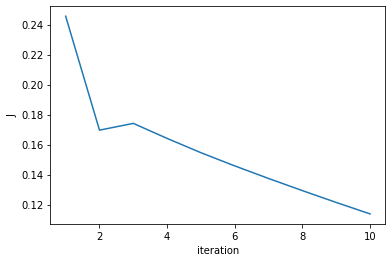

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.linalg as la

def sigma(x):
    return np.tanh(x)

def sigma_der(x):
    val = 1-np.tanh(x)**2
    #val[np.isnan(val)] = 0 
    return val
    

def eta(x):
    #0.5*(1+np.tanh(x/2))
    return x


def eta_der(x):
    #val = 0.25*(1-np.tanh(x/2)**2)
    #val[np.isnan(val)] = 0 
    val = 1
    return val

#for adams
def root(v_j):
    for i in range(4):
        v_j[i] = np.sqrt(v_j[i])
    return v_j


class Parameters:
    def __init__(self,K,d,I,iterations):
        self.W_k = np.random.randn(K,d,d)
        self.b_k = np.random.randn(K,d,1)
        self.b_k_I = np.zeros((K,d,I))
        for i in range(K):
            self.b_k_I[i,:,:] = self.b_k[i,:,:]

        self.omega = np.random.randn(d)  
        self.my = np.random.rand()
        self.K = K
        
        #for Adam descent
        self.beta_1 = 0.9; self.beta_2 = 0.999; self.alpha = 0.01; self.epsilon = 10E-8
        self.v = [0]; self.m = [0]
        
        
    def update(self,gradient,method,tau,j):
        if(method == "vanilla"):
            self.W_k = self.W_k - tau*gradient[0]
            self.b_k = self.b_k - tau*gradient[1]
            for i in range(self.K):
                self.b_k_I[i,:,:] = self.b_k[i,:,:]
            self.omega = self.omega - tau*gradient[2]
            self.my = self.my - tau*gradient[3]
            
        elif(method == "adams"):
            g = gradient 
            self.m.append( self.beta_1*self.m[j-1] + (1-self.beta_1)*g)
            self.v.append(self.beta_2*self.v[j-1]+(1-self.beta_2)*(g*g))
            m_hat = self.m[j]/(1-self.beta_1**j)
            v_hat = self.v[j]/(1-self.beta_2**j)
            subtract = self.alpha*m_hat/(root(self.v[j])+self.epsilon)
            
            self.W_k = self.W_k - subtract[0]
            self.b_k = self.b_k - subtract[1]
            for i in range(self.K):
                self.b_k_I[i,:,:] = self.b_k[i,:,:]
            self.omega = self.omega - subtract[2]
            self.my = self.my - subtract[3]      
                      
        else:
            print("No method found") 
    


class Network:
    def __init__(self,K,d,I,h,Y_0,c,iterations):
        self.U = Parameters(K,d,I,iterations)
        self.Y_list = np.zeros((K+1,d,I))
        self.Y_list[0,:,:] = Y_0
        self.h = h
        self.K = K
        self.I = I
        self.d = d
        self.Z = None

    
    def forward_function(self): # returns Z
        for i in range(self.K):
            #jmf. formel (1) i heftet
            self.Y_list[i+1,:,:] = self.Y_list[i,:,:] + self.h*sigma(self.U.W_k[i,:,:] @ self.Y_list[i,:,:] + self.U.b_k_I[i,:,:])
            
        YT_K = np.transpose(self.Y_list[-1,:,:]) #Enklere notasjon
        one_vec = np.ones(self.I)
        '''
        print("comp1")
        print(YT_K @ self.U.omega)
        print("comp2")
        print(self.U.my*one_vec)
        print("input Z")
        print(YT_K @ self.U.omega + self.U.my*one_vec)
        '''
        Z = eta(YT_K @ self.U.omega + self.U.my*one_vec)
        self.Z = Z
        return Z  #Z er en Ix1 vektor
        
    
    def back_propagation(self,Z,c): # returns gradient of J
        YT_K = np.transpose(self.Y_list[-1,:,:])
        one_vec = np.ones(self.I)
        print(Z)
        print(c)
        J_der_my =  np.transpose(one_vec) @ (Z-c)     #eta_der(YT_K @ self.U.omega + self.U.my*one_vec) @ (Z-c)    #Blir en skalar  
        J_der_omega = self.Y_list[-1,:,:] @ ((Z-c) * eta_der(YT_K @ self.U.omega + self.U.my*one_vec)) #Blir en dx1 vektor
        
        P_K = np.outer(self.U.omega,(Z-c)*eta_der(YT_K @ self.U.omega + self.U.my*one_vec)) #Blir en dxI matrise
        
        
        P_list = np.zeros((self.K,self.d,self.I)) #K matriser, skal ikke ha med P_0
        P_list[-1,:,:] = P_K      #Legger P_K bakerst i P_list
        for i in range(self.K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
            P_list[i-1,:,:] = P_list[i,:,:] + self.h*np.transpose(self.U.W_k[i-1,:,:]) @ (sigma_der(self.U.W_k[i-1,:,:] @ self.Y_list[i-1,:,:] +self.U.b_k_I[i-1,:,:]) * P_list[i,:,:])

        J_der_W = np.zeros((self.K,self.d,self.d))
        J_der_b = np.zeros((self.K,self.d,1))
        one_vec = np.ones((self.I,1))  #Må gjøre vec_I til en matrise av en eller annen grunn
        #P_Kk går fra P_1(=indeks 0) til P_K(=indeks K-1)
        
        for i in range(self.K):
            val = P_list[i,:,:] * sigma_der(self.U.W_k[i,:,:] @ self.Y_list[i,:,:] + self.U.b_k_I[i,:,:])
            J_der_W[i,:,:] = self.h*(val @ np.transpose(self.Y_list[i,:,:]))
            J_der_b[i,:,:] = self.h*(val @ one_vec)
        
        gradient = np.array((J_der_W,J_der_b,J_der_omega,J_der_my))
        
        return gradient
    
    def J(self,Z,c): #Objective function
        
        '''
        sum = 0
        for i in range(self.I):
            sum += abs(Z[i]-c[i])**2
        '''
            
        return 0.5 * la.norm(Z - c)**2
    

    
def algorithm(I,d,K,h):
    I = 2
    d = 2
    iterations = 10 #kan økes til 40 000
    tau = 0.1

        
    
    function = TestFunction(1, d, I)
    Y_0 = function.input
    c = function.solution
    print(c)
        

    NN = Network(K,d,I,h,Y_0,c,iterations)
    
    #for plotting J
    J_list = np.zeros(iterations)
    iter = np.zeros(iterations)
    
    for j in range(1,iterations+1):
        
        Z = NN.forward_function()
        print("Z:")
        print(Z)
        gradient = NN.back_propagation(Z,c)
        NN.U.update(gradient,"adams",tau,j)
        
        print("J:")
        print(NN.J(Z,c))
        J_list[j-1] = NN.J(Z,c)
        iter[j-1] = j
        
    plt.figure()
    plt.plot(iter,J_list)
    plt.ylabel("J")
    plt.xlabel("iteration")
    plt.show()
    
class TestFunction:
    def __init__(self,d0,d,I):
        self.domain = [-2,2]
        self.input = self.generate_input(d,I)
        self.solution = self.generate_solution(I)
        self.d0 = d0
    
    def f1(self, x):
        return 0.5*x**2
    
    def generate_input(self,d,I):
        result = np.zeros((d,I))
        for i in range(I):
            num = np.random.uniform(self.domain[0],self.domain[1])
            result[:,i] = np.repeat(num,d)
        return result
    
    def generate_solution(self,I):
        result = np.zeros(I)
        for i in range(I):
            result[i] = self.f1(self.input[0,i])
        return result
    
algorithm(2,2,3,0.1)
        
        

In [11]:
A = np.random.uniform(-2,2,(12,12))
print(A.shape)

(12, 12)
